In [148]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import csv, json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display, Image as IImage
from io import StringIO
from pyathena import connect
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [149]:
# Initialize Boto3 Rekognition client

rekognition_client = boto3.client("rekognition")
s3 = boto3.client("s3")

# Detect labels in Traffic sign images

In [150]:
# Define s3 bucket name, prefix and output csv file path

bucket_name = 'finalprojectdata'
prefix_key = 'traffic_signs/'
output_csv_key = 'csv_files/traffic_signs.csv'

In [151]:
# Function to detect text from an image 

def detect_text_from_image(bucket_name, image_key):
    if image_key.endswith('.jpg'):
        rekognition_response = rekognition_client.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': image_key}})
        return rekognition_response

In [152]:
# Get a list of objects in the s3 bucket

# all_results = []

# paginator = s3.get_paginator('list_objects_v2')
# result = paginator.paginate(Bucket=bucket_name, Prefix=prefix_key)

# for page in result:
#     if "Contents" in page:
#         for key in page[ "Contents" ]:
#             keyString = key[ "Key" ]
#             print(keyString)
#             if keyString.endswith('.jpg'):
#                 response = detect_text_from_image(bucket_name, keyString)
#                 all_results.append({'Image': keyString, 'TextDetections': response['TextDetections']})

In [153]:
# # Write aggregated results to a single CSV file

# csv_buffer = StringIO()
# writer = csv.DictWriter(csv_buffer, fieldnames=['Image', 'DetectedText', 'Type', 'Confidence'])
# writer.writeheader()
# for result in all_results:
#     image_key = result['Image']
#     for detection in result['TextDetections']:
#         detected_text = detection['DetectedText']
#         text_type = detection['Type']
#         confidence = detection['Confidence']
#         writer.writerow({'Image': image_key, 'DetectedText': detected_text, 'Type': text_type, 'Confidence': confidence})
        
# # Upload CSV string to S3

# csv_buffer.seek(0)
# s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_csv_key)

# print(f"Text detection results saved to: s3://{bucket_name}/{output_csv_key}")

In [154]:
# Create athena database

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

ingest_create_athena_db_passed = False

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [155]:
# Set Athena database name

database_name = "velocityvision"

In [156]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [157]:
# Connect to s3 using PyAthena

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [158]:
# SQL statement to execute

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS velocityvision


""


In [159]:
input_data_location = "s3://finalprojectdata/csv_files"

In [160]:
# SQL statement to execute the traffic signs text detection

table_name1 = 'traffic_signs'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name1}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name1}(
            image_id string,
            detected_text string,
            type string,
            confidence float
            )
            
            ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
            LOCATION '{input_data_location}'
            TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name1} LIMIT 5', conn)

,image_id,detected_text,type,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,LINE,99.548250
1,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,RYARSH,LINE,99.415030
2,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,Please reduce,LINE,99.164894
3,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,your speed,LINE,99.207320
4,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,WORD,99.548250


In [161]:
# SQL statement to filter rows for "WORD" type

query1 = "SELECT * FROM {}.{} WHERE type='WORD'".format(database_name, table_name1)
traffic_signs_df = pd.read_sql(query1, conn)

In [162]:
traffic_signs_df.shape

(22975, 4)

## Checking duplicate values

In [163]:
traffic_signs_df.duplicated().sum()

7993

In [164]:
# Removing duplicate rows

traffic_signs_df.drop_duplicates(inplace = True)
traffic_signs_df.shape

(14982, 4)

In [165]:
traffic_df = traffic_signs_df.groupby(['image_id', 'type']).agg({'detected_text': ' '.join, 'confidence':'max'}).reset_index()
traffic_df.head()

,image_id,type,detected_text,confidence
0,license_plate/license_1/00009e5b390986a0.jpg,WORD,Bel & The Dragen a Eating Ноква Te Days P طنية...,98.897190
1,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,MG Dr Bragan Joseph SANG P -,87.967316
2,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,15 118 and التحج your,83.933174
3,license_plate/license_1/00009e5b390986a0_jpg.r...,WORD,M 10r Вори People Rainy,57.783930
4,license_plate/license_1/0002a5b67e5f0909_jpg.r...,WORD,и Andrews Church DS00 PCZ,98.522736


In [166]:
# SQL statement to execute the analysis of vehicle speed

table_name2 = 'vehicle_speed'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
             latitude float,
             longitude float,
             target_speed float,
             way_maxspeed float,
             speed_osrm float,
             elevation float,
             fwd_azimuth float,
             way_type string,
             way_surface string,
             node_intersection string,
             node_railway string,
             node_crossing string,
             node_highway string,
             node_stop string,
             start_stop int,
             azimuth_diff int,
             elevation_diff float
             )
             
             ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
             LOCATION 's3://finalprojectdata/vehicle_speed'
             TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

""


In [167]:
vehicle_speed_df = pd.read_sql(f'SELECT * FROM {database_name}.{table_name2}', conn)
vehicle_speed_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,...,node_highway,node_stop,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,...,,,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,...,,,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,...,,,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,...,,,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,...,,,0,0.0,-0.025587


# Exploratory Data Analysis

In [168]:
vehicle_speed_df.shape

(12165, 17)

Text(0, 0.5, 'Count')

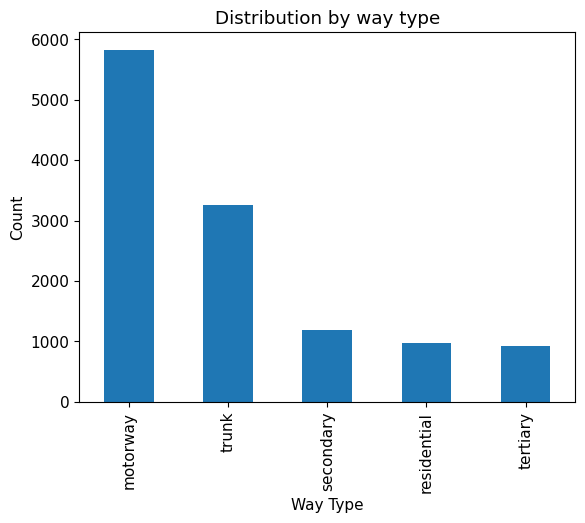

In [169]:
# Distrubition by Way type

vehicle_speed_df['way_type'].value_counts().plot(kind="bar", title="Distribution by way type")
plt.xlabel("Way Type")
plt.ylabel("Count")

# Correlation

Lets study the correlation between different attributes in the dataset

In [170]:
corr = vehicle_speed_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', cbar_kws={'label': 'Correlation Index'})

ValueError: could not convert string to float: 'motorway'

From the above correlation Heatmap, it is observed that the below predictors are highly correlated.
(1) latitude and elevation
(2) target_speed and way_maxspeed
(3) way_maxspeed and speed_osrm
(4) target_speed and elevation

# 2. Data Preprocessing

## 2.1. Handling Missing Values

In [171]:
vehicle_speed_df.isnull().sum()

latitude             0
longitude            0
target_speed         0
way_maxspeed         0
speed_osrm           0
elevation            0
fwd_azimuth          0
way_type             0
way_surface          0
node_intersection    0
node_railway         0
node_crossing        0
node_highway         0
node_stop            0
start_stop           0
azimuth_diff         7
elevation_diff       0
dtype: int64

In [172]:
# Dropping columns that have null values

vehicle_speed_df = vehicle_speed_df.drop(['node_intersection', 'node_railway', 'node_crossing', 'node_highway', 'node_stop'], axis=1)

# Dropping rows that have null values

vehicle_speed_df = vehicle_speed_df.dropna(subset=['azimuth_diff'])

In [173]:
vehicle_speed_df.duplicated().sum()

0

# Multicollinearity

Lets address the multicollinearity issue by calculating Variance Inflation Factor (VIF) and removing highly correlated predictors.

In [174]:
# Separate the predictors and target variables

X_pred = vehicle_speed_df.drop(['target_speed'], axis=1)
y_target = vehicle_speed_df['target_speed']

In [175]:
# Calculate correlation matrix for predictors
correlation_matrix = X_pred.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

ValueError: could not convert string to float: 'motorway'

To address the issue of multicollinearity, it is suggested to remove the columns longitude, way_maxspeed, and elevation. However, since determining the target speed of a vehicle relies on multiple factors, including spatial information about the vehicle's location, both latitude and longitude should be taken into account.

# Feature transformation

The maximum allowed speed is measured in km/hr whereas target_speed and speed_osrm are measured in m/s. Hence transforming the target_speed and speed_osrm values to km/hr

In [176]:
# Convert m/s to km/hr for the target_speed and speed_osrm column

vehicle_speed_df['target_speed'] = vehicle_speed_df['target_speed'] * 3.6

vehicle_speed_df['speed_osrm'] = vehicle_speed_df['speed_osrm'] * 3.6

# Feature Creation

Lets create a new feature speed_deviation that computes the difference between target_speed and way_maxspeed to see if the vehicle is driving above or below the allowed speed limit.

In [177]:
vehicle_speed_df['speed_deviation'] = vehicle_speed_df['target_speed'] - vehicle_speed_df['way_maxspeed']

# Drop Irrelevant fields

In [178]:
# Dropping fields that exhibit multicollinearity 

vehicle_speed_df = vehicle_speed_df.drop(['way_maxspeed', 'elevation'], axis=1)

# Dropping irrelevant columns

vehicle_speed_df = vehicle_speed_df.drop(['fwd_azimuth', 'way_surface', 'start_stop', 'azimuth_diff', 'elevation_diff'], axis=1)

# Feature Selection

Based on the insights from the correlation matrix heatmap and other transformation techniques, the useful predictors for the final model include: latitude, longitude, speed_osrm, way_type, speed_deviation and target_speed.

In [179]:
final_df = vehicle_speed_df.copy()

# Encoding Categorical Variables

In [180]:
# Convert categorical variables to dummy variables

final_df = pd.get_dummies(final_df, columns= ['way_type'], drop_first=True)
final_df.head()

,latitude,longitude,target_speed,speed_osrm,speed_deviation,way_type_residential,way_type_secondary,way_type_tertiary,way_type_trunk
0,50.397060,14.913273,143.062042,103.814086,13.062042,False,False,False,False
1,50.397068,14.913283,142.984026,103.952261,12.984026,False,False,False,False
2,50.397076,14.913294,142.906010,104.090425,12.906010,False,False,False,False
3,50.397080,14.913303,142.827991,104.228593,12.827991,False,False,False,False
4,50.397087,14.913314,142.749972,104.366761,12.749972,False,False,False,False


# Data Partitioning

## Separate predictor and target variables

In [181]:
# Separate X and y variables

X = final_df.drop(['target_speed'], axis=1)
y = final_df['target_speed']
predictors = X.columns
outcome = 'target_speed'

## Split dataset into training, test and validation sets

In [182]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Split the test and validation set
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [183]:
# Proportions of training, test and validation data

train_prop = len(X_train)/len(final_df)
test_prop = len(X_test)/len(final_df)
valid_prop = len(X_valid)/len(final_df)

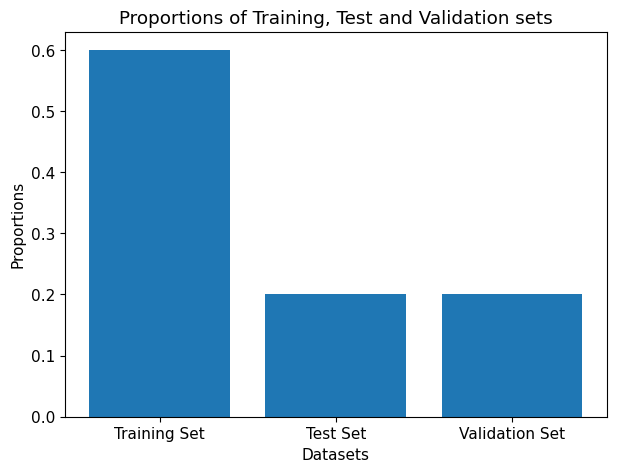

In [184]:
plt.figure(figsize=(7,5))
labels = ['Training Set', 'Test Set', 'Validation Set']
proportions = [train_prop, test_prop, valid_prop]
plt.bar(labels,proportions)
plt.xlabel("Datasets")
plt.ylabel("Proportions")
plt.title("Proportions of Training, Test and Validation sets")
plt.show()

# New attempt for license plate detection

In [185]:
# Install required packages
#!pip install boto3 matplotlib

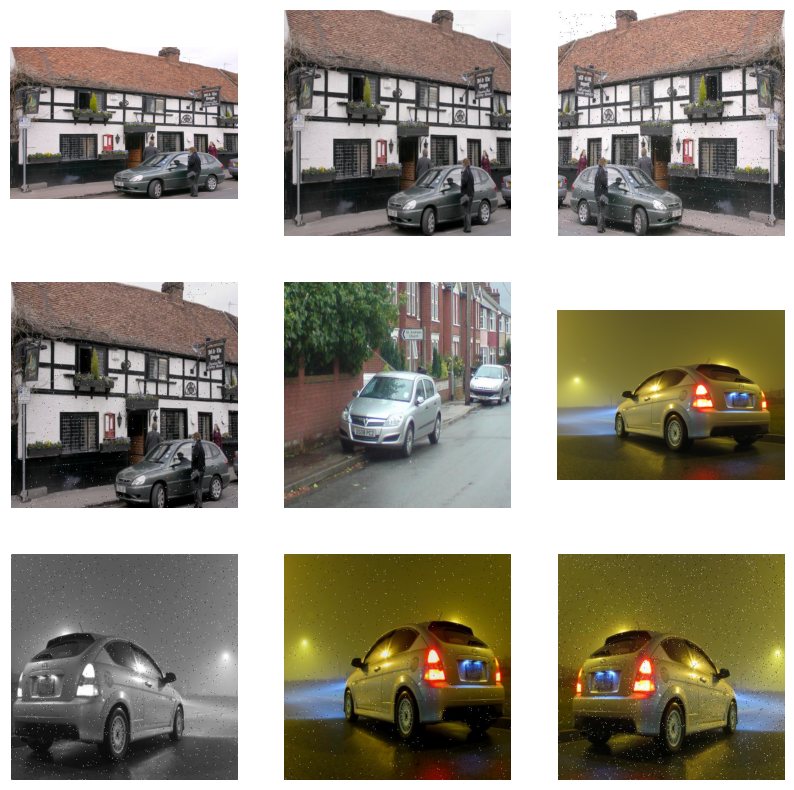

In [186]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from io import BytesIO

# Connect to S3
s3 = boto3.client('s3', region_name='us-east-1')

# Bucket name and prefix
bucket_name = 'final.project.data.508'
prefix = 'license_plate/license_1/'

# List objects in the bucket
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Extracting S3 URIs of images
image_uris = [obj['Key'] for obj in response['Contents']]

# Function to display mosaic of images
def display_mosaic(image_uris):
    num_images = min(len(image_uris), 9)  # Display up to 9 images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(num_images):
        row = i // 3
        col = i % 3
        # Download image from S3
        obj = s3.get_object(Bucket=bucket_name, Key=image_uris[i])
        img_data = obj['Body'].read()
        img = mpimg.imread(BytesIO(img_data), format='jpg')
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
    plt.show()

# Display mosaic of the first 9 images
display_mosaic(image_uris[:9])

In [187]:
#conda create -n license_plate_detection python=3.8
#conda activate license_plate_detection

In [188]:
!apt update
!apt install -y libgl1-mesa-glx

Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:3 http://security.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:4 http://security.debian.org/debian-security bullseye-security/main amd64 Packages [271 kB]
Fetched 363 kB in 1s (553 kB/s)    
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
61 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.3.5-1).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.


In [189]:
# Install YOLOv5
#!pip install yolov5

In [190]:
import torch
from yolov5.models.experimental import attempt_load
import cv2
import numpy as np
import random
import boto3
from PIL import Image
from io import BytesIO

def scale_coords(coords, img_shape, ratio_pad=None):
    # Implementation of scale_coords function
    # Your implementation here
    pass

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return img

# Use the attempt_load function from the appropriate file
model = attempt_load(weights='yolov5s.pt')

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [191]:
#!pip install torch

In [192]:
# Figure out dimensions and model requirements
import torch

print("Data type:", image_tensor.dtype)  # Print the data type of the tensor
print("Shape:", image_tensor.shape)      # Print the shape of the tensor
print("Size:", image_tensor.size())      # Print the total number of elements in the tensor

# If the tensor is a 2D tensor 
if len(image_tensor.shape) == 2:
    print("Height:", image_tensor.shape[0])  # Print the height of the image
    print("Width:", image_tensor.shape[1])   # Print the width of the image

Data type: torch.float32
Shape: torch.Size([1, 3, 416, 416])
Size: torch.Size([1, 3, 416, 416])


In [193]:
# Trying to pre-process the image based on previously indicated conditions

import torch
from yolov5.models.experimental import attempt_load
import cv2
import numpy as np
import random
import boto3
from PIL import Image
from io import BytesIO

# Connect to the S3 bucket
s3 = boto3.client('s3')

# S3 bucket name and object key
bucket_name = 'final.project.data.508'
object_key = 'license_plate/license_1/00009e5b390986a0_jpg.rf.45e96daccb301ab8278c3988c1ee192e.jpg'

try:
    # Download the image from S3
    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    image_data = response['Body'].read()

    # Read the image using PIL
    image = Image.open(BytesIO(image_data))

    # Convert image to RGB mode
    image = image.convert('RGB')

    # Convert image to NumPy array
    image_np = np.array(image)

    # Convert image to RGB
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Resize image to match model input size (416x416)
    input_size = (416, 416)
    image_resized = cv2.resize(image_bgr, input_size)

    # Convert image to PyTorch tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

    # Print image tensor specifications
    print("Data type:", image_tensor.dtype)
    print("Shape:", image_tensor.shape)
    print("Size:", image_tensor.size())

except Exception as e:
    print("Failed to download image from S3:", e)

Data type: torch.float32
Shape: torch.Size([1, 3, 416, 416])
Size: torch.Size([1, 3, 416, 416])


In [194]:
try:
    # Load YOLOv5 model
    model = attempt_load(weights='yolov5s.pt')

    # Set model to evaluation mode
    model.eval()

    # Perform inference on the pre-processed image
    with torch.no_grad():
        # Convert image tensor to appropriate data type (float32) and move it to the device (CPU)
        image_tensor = image_tensor.float()  # Convert to float32
        image_tensor = image_tensor.to(torch.device('cpu'))  # Move to CPU

        # Perform inference
        detections = model(image_tensor)

        # Process model output
        # You can further process the 'detections' object to extract bounding box coordinates, class predictions, etc.
        # For example, you can use the 'xyxy' format to represent bounding boxes.
        # Each row in 'detections' corresponds to a detected object, where the first 4 values represent the coordinates of the bounding box,
        # and the fifth value represents the confidence score.
        # You can filter out detections based on confidence threshold and visualize the results.

        # Example code to print detections
        print("Detections:")
        for det in detections:
            print(det)

except Exception as e:
    print("Failed to perform inference with YOLOv5 model:", e)


Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


Detections:
tensor([[[2.75417e+00, 4.58951e+00, 6.16099e+00,  ..., 4.04478e-03, 1.26405e-03, 2.89161e-03],
         [1.05853e+01, 4.58219e+00, 2.04994e+01,  ..., 4.11406e-03, 1.07194e-03, 1.88697e-03],
         [1.81600e+01, 3.63003e+00, 2.77084e+01,  ..., 2.28905e-03, 1.00695e-03, 1.76817e-03],
         ...,
         [3.34117e+02, 3.85182e+02, 1.45161e+02,  ..., 1.54364e-03, 9.07870e-04, 8.15414e-04],
         [3.66219e+02, 3.95439e+02, 1.72546e+02,  ..., 1.23449e-03, 8.54846e-04, 8.23620e-04],
         [4.02992e+02, 3.97459e+02, 1.57190e+02,  ..., 1.41680e-03, 8.21184e-04, 8.17896e-04]]])
[tensor([[[[[-3.14012e-01,  1.47646e-01, -4.36984e-01,  ..., -5.50628e+00, -6.67217e+00, -5.84305e+00],
           [-3.57440e-01,  1.45805e-01,  9.24116e-01,  ..., -5.48922e+00, -6.83721e+00, -6.27089e+00],
           [-4.68379e-01, -9.25590e-02,  1.60195e+00,  ..., -6.07733e+00, -6.89982e+00, -6.33604e+00],
           ...,
           [ 3.97566e-01,  2.99791e-02,  1.76309e+00,  ..., -6.56190e+00, -6

In [195]:
# Trying to pre-process the image based on previously indicated conditions

import torch
from yolov5.models.experimental import attempt_load
import cv2
import numpy as np
import boto3
from PIL import Image
from io import BytesIO

# Connect to the S3 bucket
s3 = boto3.client('s3')

# S3 bucket name and object key
bucket_name = 'final.project.data.508'
object_key = 'license_plate/license_1/00009e5b390986a0_jpg.rf.45e96daccb301ab8278c3988c1ee192e.jpg'

try:
    # Download the image from S3
    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    image_data = response['Body'].read()

    # Read the image using PIL
    image = Image.open(BytesIO(image_data))

    # Convert image to RGB mode
    image = image.convert('RGB')

    # Convert image to NumPy array
    image_np = np.array(image)

    # Convert image to BGR
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Resize image to match model input size (416x416)
    input_size = (416, 416)
    image_resized = cv2.resize(image_bgr, input_size)

    # Convert image to PyTorch tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

    # Print image tensor specifications
    print("Data type:", image_tensor.dtype)
    print("Shape:", image_tensor.shape)
    print("Size:", image_tensor.size())

except Exception as e:
    print("Failed to download image from S3:", e)

Data type: torch.float32
Shape: torch.Size([1, 3, 416, 416])
Size: torch.Size([1, 3, 416, 416])


In [196]:
try:
    # Load YOLOv5 model
    model = attempt_load(weights='yolov5s.pt')

    # Set model to evaluation mode
    model.eval()

    # Perform inference on the pre-processed image
    with torch.no_grad():
        # Convert image tensor to appropriate data type (float32) and move it to the device (CPU)
        image_tensor = image_tensor.float()  # Convert to float32
        image_tensor = image_tensor.to(torch.device('cpu'))  # Move to CPU

        # Perform inference
        detections = model(image_tensor)

        # Process model output
        # You can further process the 'detections' object to extract bounding box coordinates, class predictions, etc.
        # For example, you can use the 'xyxy' format to represent bounding boxes.
        # Each row in 'detections' corresponds to a detected object, where the first 4 values represent the coordinates of the bounding box,
        # and the fifth value represents the confidence score.
        # You can filter out detections based on confidence threshold and visualize the results.

        # Example code to print detections
        print("Detections:")
        for det in detections:
            print(det)

except Exception as e:
    print("Failed to perform inference with YOLOv5 model:", e)

Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


Detections:
tensor([[[2.75417e+00, 4.58951e+00, 6.16099e+00,  ..., 4.04478e-03, 1.26405e-03, 2.89161e-03],
         [1.05853e+01, 4.58219e+00, 2.04994e+01,  ..., 4.11406e-03, 1.07194e-03, 1.88697e-03],
         [1.81600e+01, 3.63003e+00, 2.77084e+01,  ..., 2.28905e-03, 1.00695e-03, 1.76817e-03],
         ...,
         [3.34117e+02, 3.85182e+02, 1.45161e+02,  ..., 1.54364e-03, 9.07870e-04, 8.15414e-04],
         [3.66219e+02, 3.95439e+02, 1.72546e+02,  ..., 1.23449e-03, 8.54846e-04, 8.23620e-04],
         [4.02992e+02, 3.97459e+02, 1.57190e+02,  ..., 1.41680e-03, 8.21184e-04, 8.17896e-04]]])
[tensor([[[[[-3.14012e-01,  1.47646e-01, -4.36984e-01,  ..., -5.50628e+00, -6.67217e+00, -5.84305e+00],
           [-3.57440e-01,  1.45805e-01,  9.24116e-01,  ..., -5.48922e+00, -6.83721e+00, -6.27089e+00],
           [-4.68379e-01, -9.25590e-02,  1.60195e+00,  ..., -6.07733e+00, -6.89982e+00, -6.33604e+00],
           ...,
           [ 3.97566e-01,  2.99791e-02,  1.76309e+00,  ..., -6.56190e+00, -6

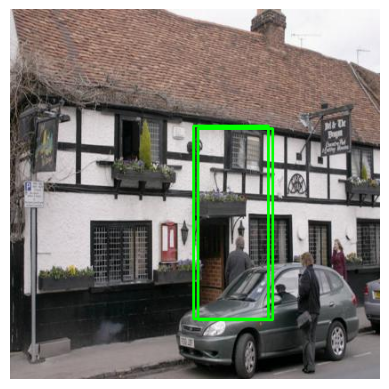

In [197]:
# Can delete this chunk of code as it did not generate an image for me

import matplotlib.pyplot as plt

# Loop through each detection and draw bounding boxes on the original image
for detection in detections:
    for det in detection:
        # Iterate over each detection tensor and extract confidence score
        for i in range(len(det)):
            # Check if the detection tensor has enough values
            if len(det[i]) >= 5:
                # Extract the coordinates and confidence score from the detection
                x1, y1, x2, y2, confidence = det[i][:5]

                # Extract the scalar value from the tensor for confidence
                confidence = confidence.item()

                # If the confidence score is above a certain threshold, draw the bounding box
                if confidence > 0.9:
                    # Scale the coordinates to match the original image size
                    x1 = int(x1)
                    y1 = int(y1)
                    x2 = int(x2)
                    y2 = int(y2)

                    # Draw the bounding box on the original image
                    cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert the image back to RGB for display
image_with_boxes = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

Image with boxes shape: (416, 416, 3)
Sample image data: [[[217 205 205]
  [214 203 201]
  [163 147 147]
  [124 109 104]
  [117  98  94]
  [131 111 104]
  [157 134 126]
  [139 115 105]
  [148 121 110]
  [141 114 103]]

 [[229 217 217]
  [205 193 193]
  [161 147 146]
  [154 139 136]
  [149 131 127]
  [132 112 105]
  [135 112 104]
  [122  98  88]
  [132 105  94]
  [146 119 108]]

 [[223 213 212]
  [213 201 201]
  [174 160 159]
  [154 139 136]
  [155 137 133]
  [159 139 132]
  [152 129 121]
  [118  94  84]
  [104  77  66]
  [121  94  83]]

 [[211 201 200]
  [223 213 212]
  [197 186 184]
  [147 133 130]
  [123 105 101]
  [137 118 111]
  [155 132 126]
  [149 124 117]
  [119  92  83]
  [ 97  70  59]]

 [[214 205 206]
  [218 208 207]
  [208 197 195]
  [162 148 145]
  [107  89  85]
  [ 87  68  61]
  [117  94  88]
  [161 136 129]
  [170 143 134]
  [139 112 103]]

 [[220 211 212]
  [213 204 205]
  [201 191 190]
  [157 146 142]
  [126 111 106]
  [120 103  96]
  [114  94  87]
  [122  99  91]
  [15

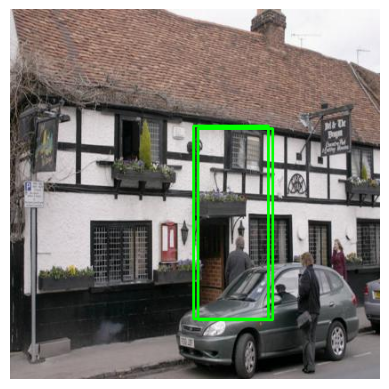

Image displayed successfully.


In [198]:
import matplotlib.pyplot as plt

# Debugging: Print image shape and sample data
print("Image with boxes shape:", image_with_boxes.shape)
print("Sample image data:", image_with_boxes[:10, :10, :])

# Display the image with bounding boxes
print("Attempting to display the image...")
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()
print("Image displayed successfully.")

In [199]:
# Save the image with bounding boxes to a file
output_file = "output_image_with_boxes.jpg"
cv2.imwrite(output_file, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))

print("Image with bounding boxes saved to:", output_file)

Image with bounding boxes saved to: output_image_with_boxes.jpg


In [200]:
# Increase requirements to detect objects and apply to different photos

import torch
import cv2
import boto3
import numpy as np
from PIL import Image
from io import BytesIO
from yolov5.models.experimental import attempt_load

# Connect to the S3 bucket
s3 = boto3.client('s3')

# S3 bucket name and object key
bucket_name = 'final.project.data.508'
object_key = 'license_plate/license_1/00043e7c5c4c025a_jpg.rf.caaee598dbfb1b441b9efea248639462.jpg'

try:
    # Download the image from S3
    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    image_data = response['Body'].read()

    # Read the image using PIL
    image = Image.open(BytesIO(image_data))

    # Convert image to RGB mode
    image = image.convert('RGB')

    # Convert image to NumPy array
    image_np = np.array(image)

    # Convert image to BGR
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Resize image to match model input size (416x416)
    input_size = (416, 416)
    image_resized = cv2.resize(image_bgr, input_size)

    # Convert image to PyTorch tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

    # Print image tensor specifications
    print("Data type:", image_tensor.dtype)
    print("Shape:", image_tensor.shape)
    print("Size:", image_tensor.size())

except Exception as e:
    print("Failed to download image from S3:", e)

try:
    # Load YOLOv5 model
    model = attempt_load(weights='yolov5s.pt')

    # Set model to evaluation mode
    model.eval()

    # Perform inference on the pre-processed image
    with torch.no_grad():
        # Convert image tensor to appropriate data type (float32) and move it to the device (CPU)
        image_tensor = image_tensor.float()  # Convert to float32
        image_tensor = image_tensor.to(torch.device('cpu'))  # Move to CPU

        # Perform inference
        detections = model(image_tensor)

        # Check the type of detections
        if isinstance(detections, tuple):
            # Extract the first element of the tuple
            detections = detections[0]

            # Process model output
            # You can further process the 'detections' object to extract bounding box coordinates, class predictions, etc.
            # For example, you can use the 'xyxy' format to represent bounding boxes.
            # Each row in 'detections' corresponds to a detected object, where the first 4 values represent the coordinates of the bounding box,
            # and the fifth value represents the confidence score.
            # You can filter out detections based on confidence threshold and visualize the results.

            # Check the size of detections
            if detections.ndim == 2 and detections.shape[0] > 0:
                # Extract bounding boxes and confidences
                boxes = detections[:, :4]
                confidences = detections[:, 4]

                # Sort detections by confidence scores in descending order
                sorted_indices = torch.argsort(-confidences)

                # Select top 10 detections
                top_indices = sorted_indices[:10]
                top_boxes = boxes[top_indices]
                top_confidences = confidences[top_indices]

                # Draw bounding boxes on the image
                for box, confidence in zip(top_boxes, top_confidences):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Convert the image back to RGB for display
                image_with_boxes = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Save the image with bounding boxes to a file
                output_file = "output_image_with_boxes.jpg"
                cv2.imwrite(output_file, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))

                print("Image with bounding boxes saved to:", output_file)
            else:
                print("No detections found.")
        else:
            print("Unexpected format of detections:", detections)

except Exception as e:
    print("Failed to perform inference with YOLOv5 model:", e)

Data type: torch.float32
Shape: torch.Size([1, 3, 416, 416])
Size: torch.Size([1, 3, 416, 416])


Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


No detections found.


In [201]:
# Try to apply onto the entire folder to save only objects with detections

import torch
import cv2
import boto3
import numpy as np
from PIL import Image
from io import BytesIO
from yolov5.models.experimental import attempt_load

# Connect to the S3 bucket
s3 = boto3.client('s3')

# S3 bucket name and object prefix
bucket_name = 'final.project.data.508'
object_prefix = 'license_plate/license_1/'

# Load YOLOv5 model
model = attempt_load(weights='yolov5s.pt').eval()

# Iterate over objects in the S3 bucket directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=object_prefix)
for obj in response.get('Contents', []):
    object_key = obj['Key']

    try:
        # Download the image from S3
        response = s3.get_object(Bucket=bucket_name, Key=object_key)
        image_data = response['Body'].read()

        # Read the image using PIL
        image = Image.open(BytesIO(image_data))

        # Convert image to RGB mode
        image = image.convert('RGB')

        # Convert image to NumPy array
        image_np = np.array(image)

        # Convert image to BGR
        image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        # Resize image to match model input size (416x416)
        input_size = (416, 416)
        image_resized = cv2.resize(image_bgr, input_size)

        # Convert image to PyTorch tensor
        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            detections = model(image_tensor)[0]

            # Check if detections exist and are in the expected format
            if detections.ndim == 2 and detections.shape[0] > 0:
                # Extract bounding boxes and confidences
                boxes = detections[:, :4]
                confidences = detections[:, 4]

                # Sort detections by confidence scores in descending order
                sorted_indices = torch.argsort(-confidences)

                # Select top 50 detections
                top_indices = sorted_indices[:50]
                top_boxes = boxes[top_indices]
                top_confidences = confidences[top_indices]

                # Draw bounding boxes on the image
                for box, confidence in zip(top_boxes, top_confidences):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Convert the image back to RGB for display
                image_with_boxes = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Save the image with bounding boxes to a file
                output_file = f"output_{object_key.split('/')[-1]}"
                cv2.imwrite(output_file, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))

                print("Image with bounding boxes saved to:", output_file)

    except Exception as e:
        print("Failed to process image", object_key, ":", e)


Fusing layers... 
YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


In [202]:
# Trying to see if I can detect something by adjsuting the confidence requirements

import torch
import cv2
import boto3
import numpy as np
from PIL import Image
from io import BytesIO
from yolov5.models.experimental import attempt_load

# Connect to the S3 bucket
s3 = boto3.client('s3')

# S3 bucket name and object key
bucket_name = 'final.project.data.508'
object_key = 'license_plate/license_1/00043e7c5c4c025a_jpg.rf.caaee598dbfb1b441b9efea248639462.jpg'

try:
    # Download the image from S3
    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    image_data = response['Body'].read()

    # Read the image using PIL
    image = Image.open(BytesIO(image_data))

    # Convert image to RGB mode
    image = image.convert('RGB')

    # Convert image to NumPy array
    image_np = np.array(image)

    # Convert image to BGR
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Resize image to match model input size (416x416)
    input_size = (416, 416)
    image_resized = cv2.resize(image_bgr, input_size)

    # Convert image to PyTorch tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

    # Print image tensor specifications
    print("Data type:", image_tensor.dtype)
    print("Shape:", image_tensor.shape)
    print("Size:", image_tensor.size())

except Exception as e:
    print("Failed to download image from S3:", e)

try:
    # Load YOLOv5 model
    model = attempt_load(weights='yolov5s.pt')

    # Set model to evaluation mode
    model.eval()

    # Perform inference on the pre-processed image
    with torch.no_grad():
        # Convert image tensor to appropriate data type (float32) and move it to the device (CPU)
        image_tensor = image_tensor.float()  # Convert to float32
        image_tensor = image_tensor.to(torch.device('cpu'))  # Move to CPU

        # Perform inference
        detections = model(image_tensor)

        # Check the type of detections
        if isinstance(detections, tuple):
            # Extract the first element of the tuple
            detections = detections[0]

            # Process model output
            # You can further process the 'detections' object to extract bounding box coordinates, class predictions, etc.
            # For example, you can use the 'xyxy' format to represent bounding boxes.
            # Each row in 'detections' corresponds to a detected object, where the first 4 values represent the coordinates of the bounding box,
            # and the fifth value represents the confidence score.
            # You can filter out detections based on confidence threshold and visualize the results.

            # Check the size of detections
            if detections.ndim == 2 and detections.shape[0] > 0:
                # Extract bounding boxes and confidences
                boxes = detections[:, :4]
                confidences = detections[:, 4]

                # Filter detections based on confidence threshold
                confidence_threshold = 0.05  # Adjust this threshold as needed
                mask = confidences > confidence_threshold
                boxes = boxes[mask]
                confidences = confidences[mask]

                # Draw bounding boxes on the image
                for box, confidence in zip(boxes, confidences):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Convert the image back to RGB for display
                image_with_boxes = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                # Save the image with bounding boxes to a file
                output_file = "output_image_with_boxes.jpg"
                cv2.imwrite(output_file, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))

                print("Image with bounding boxes saved to:", output_file)
            else:
                print("No detections found.")
        else:
            print("Unexpected format of detections:", detections)

except Exception as e:
    print("Failed to perform inference with YOLOv5 model:", e)

Fusing layers... 


Data type: torch.float32
Shape: torch.Size([1, 3, 416, 416])
Size: torch.Size([1, 3, 416, 416])


YOLOv5s summary: 270 layers, 7235389 parameters, 0 gradients, 16.6 GFLOPs


No detections found.


# Trying new license plate data source w/ labels

## First load the data from the S3 buckets

In [246]:
# First indicate what is the total images found in the S3 bucket

# Initialize the S3 client
s3 = boto3.client('s3')

# Bucket name
bucket_name = 'final.project.data.508'

# Prefix for the folder containing images
prefix = 'upd_license_plates/'

# List objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Extract the list of object keys
if 'Contents' in response:
    file_count = len(response['Contents'])
    print("Total successful files:", file_count)
else:
    print("No images found in the bucket.")

Total successful files: 1000


In [245]:
# Determine the total photos found in the training set

# Prefix for the folder containing images
train_prefix = 'upd_license_plates/images/train/'

# List objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=train_prefix)

# Extract the list of object keys
if 'Contents' in response:
    file_count = len(response['Contents'])
    print("Total successful files in 'train' folder:", file_count)
else:
    print("No images found in the 'train' folder.")

Total successful files in 'train' folder: 1000


In [241]:
# Display a sample of 9 photos found in the train subset

# Extract the list of object keys
if 'Contents' in response:
    # Get the first 9 files from the response
    object_keys = [obj['Key'] for obj in response['Contents'][:9]]
    
    # Create a figure for the mosaic
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    axs = axs.flatten()
    
    # Loop through the object keys & display each image
    for i, key in enumerate(object_keys):
        # Load image from S3
        obj = s3.get_object(Bucket=bucket_name, Key=key)
        image = Image.open(obj['Body'])
        
        # Display image
        axs[i].imshow(image)
        axs[i].axis('off')
    
    # Show the mosaic
    plt.show()
else:
    print("No images found in the 'train' folder.")

No images found in the 'train' folder.


In [247]:
# Determine the total photos found in the validation set

# Prefix for the folder containing images
val_prefix = 'upd_license_plates/images/val/'

# List objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=val_prefix)

# Extract the list of object keys
if 'Contents' in response:
    file_count = len(response['Contents'])
    print("Total successful files in 'train' folder:", file_count)
else:
    print("No images found in the 'val' folder.")

Total successful files in 'train' folder: 1000


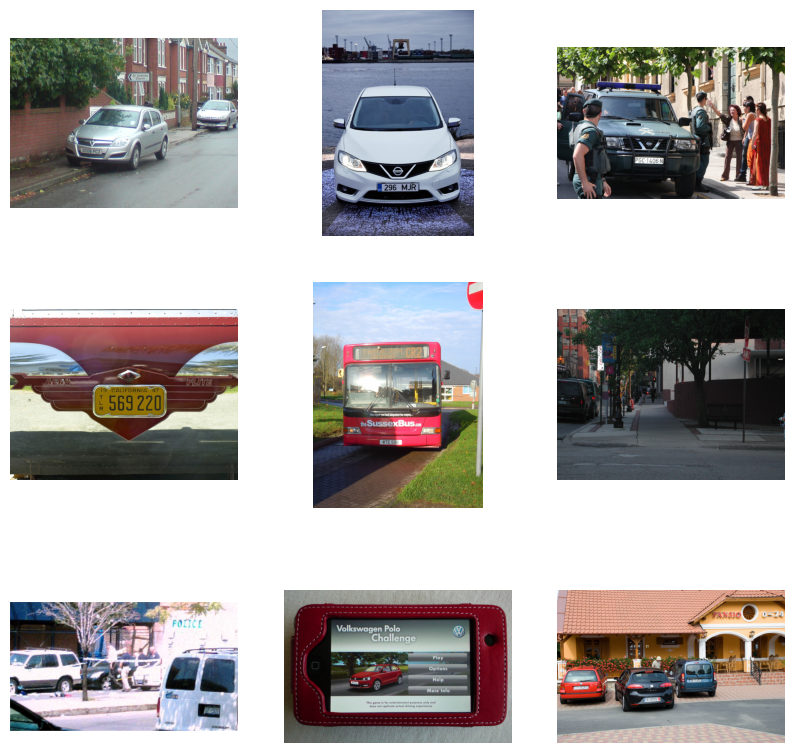

In [243]:
# Display a sample of 9 photos found in the val subset

# Extract the list of object keys
if 'Contents' in response:
    # Get the first 9 files from the response (assuming there are at least 9 images)
    object_keys = [obj['Key'] for obj in response['Contents'][:9]]
    
    # Create a figure for the mosaic
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    axs = axs.flatten()
    
    # Loop through the object keys and load/display each image
    for i, key in enumerate(object_keys):
        # Load image from S3
        obj = s3.get_object(Bucket=bucket_name, Key=key)
        image = Image.open(obj['Body'])
        
        # Display image
        axs[i].imshow(image)
        axs[i].axis('off')
    
    # Show the mosaic
    plt.show()
else:
    print("No images found in the 'val' folder.")

In [236]:
# Determine the total photos found in the test set

# Prefix for the folder containing images
test_prefix = 'upd_license_plates/images/test/'

# List objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=test_prefix)

# Extract the list of object keys
if 'Contents' in response:
    file_count = len(response['Contents'])
    print("Total successful files in 'train' folder:", file_count)
else:
    print("No images found in the 'test' folder.")

No images found in the 'test' folder.


In [237]:
# Display a sample of 9 photos found in the test subset

# Extract the list of object keys
if 'Contents' in response:
    # Get the first 9 files from the response
    object_keys = [obj['Key'] for obj in response['Contents'][:9]]
    
    # Create a figure for the mosaic
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    axs = axs.flatten()
    
    # Loop through the object keys & display each image
    for i, key in enumerate(object_keys):
        # Load image from S3
        obj = s3.get_object(Bucket=bucket_name, Key=key)
        image = Image.open(obj['Body'])
        
        # Display image
        axs[i].imshow(image)
        axs[i].axis('off')
    
    # Show the mosaic
    plt.show()
else:
    print("No images found in the 'test' folder.")

No images found in the 'test' folder.


## Overlay labels with corresponding image

In [ ]:
import boto3
import os
import cv2

# Initialize the S3 client
s3 = boto3.client('s3')

# Create a function to retrieve image & label files from S3
def list_files(bucket_name, prefix):
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    if 'Contents' in response:
        return [obj['Key'] for obj in response['Contents']]
    else:
        return []

# List image files from the 'val' folder
val_images = list_files(bucket_name, 'upd_license_plates/images/val/')
# List label files from the 'labels' folder
val_labels = list_files(bucket_name, 'upd_license_plates/labels/val/')

# Loop through each image file
for image_key in val_images:
    # Extract image file name
    image_name = os.path.basename(image_key)
    # Check if corresponding label file exists
    label_key = f'upd_license_plates/labels/val/{image_name.replace(".jpg", ".txt")}'
    if label_key in val_labels:
        # Load image from S3
        image_obj = s3.get_object(Bucket=bucket_name, Key=image_key)
        image_bytes = image_obj['Body'].read()
        image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), -1)
        
        # Load label file from S3
        label_obj = s3.get_object(Bucket=bucket_name, Key=label_key)
        label_data = label_obj['Body'].read().decode('utf-8').strip().split('\n')
        
        # Process label data and overlay bounding boxes on the image
        for line in label_data:
            class_id, center_x, center_y, width, height = map(float, line.split())
            # Convert YOLO format to bounding box coordinates
            x_min = int((center_x - width / 2) * image.shape[1])
            y_min = int((center_y - height / 2) * image.shape[0])
            x_max = int((center_x + width / 2) * image.shape[1])
            y_max = int((center_y + height / 2) * image.shape[0])
            # Draw bounding box on the image
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Display the image with bounding boxes
        cv2.imshow('Image with Bounding Boxes', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print(f"No label file found for image: {image_key}")